<a href="https://colab.research.google.com/github/MANOJ9590/Research_Lab-SS2022/blob/main/ANN_Implementation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime, timedelta
import tensorflow as tf
import pandas as pd
import numpy as np


In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/MANOJ9590/Research_Lab-SS2022/main/Daily_data.csv",delimiter = ";",index_col=False)

In [ ]:
data.drop(['Unnamed: 0'],inplace=True, axis=1)
data.dropna()
data=data.set_index('Date')
data

In [6]:
dates = np.array(data.index)
dates = [datetime.strptime(date, '%d/%m/%y').date() for date in dates]
dates = [x.strftime('%d/%m/%y') for x in dates]

confirmed_pk = np.array(data[['Confirmed Cases']])
deaths_pk = np.array(data[['Deaths']])
recovered_pk = np.array(data[['Recoveries']])

In [7]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)


In [ ]:
print('The data taken from 25 feb 2020 because 1st two case was confirmed at that day. All the previous data is emitted.\n')

df = pd.DataFrame(np.append(np.array(dates).reshape(-1,1), conf_death_recov, axis = 1), columns = ['Date', 'Confirmed Cases', 'Deaths', 'Recoveries']).dropna()


df = df[df.Recoveries != 'nan']
df

In [9]:
confirmed_pk = np.array(df[['Confirmed Cases']])
deaths_pk = np.array(df[['Deaths']])
recovered_pk = np.array(df[['Recoveries']])
dates = df['Date'].tolist()

In [10]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.pyplot import figure

In [ ]:
print(type(confirmed_pk))
print(type(deaths_pk))
print(type(recovered_pk))
print(type(dates))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 849
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             749 non-null    object
 1   Confirmed Cases  749 non-null    object
 2   Deaths           749 non-null    object
 3   Recoveries       749 non-null    object
dtypes: object(4)
memory usage: 29.3+ KB


In [13]:
from sklearn.preprocessing import PolynomialFeatures

In [14]:
poly_reg = PolynomialFeatures(degree = 6)


In [15]:
input_data_simple = np.arange(0,len(confirmed_pk)) + 1


In [16]:
input_data = poly_reg.fit_transform(input_data_simple.reshape(-1,1))


In [17]:
inputData_dates = pd.Series(dates, index = input_data_simple)


In [18]:
from sklearn.preprocessing import StandardScaler


In [19]:
scx = StandardScaler()
input_data_scaled = scx.fit_transform(input_data[:,1:])

In [20]:
def generate_future_data(inp, days_to_get):
    prep_future_data_simple = (np.arange(0, days_to_get + 1) + inp[-1]).reshape(-1,1)
    generated_future_data = poly_reg.transform(prep_future_data_simple)
    scaled_gen_future_data = scx.transform(generated_future_data[:,1:])
    # Generating Dates
    lastDate = inputData_dates[inp[-1]]
    futureDates = [datetime.strptime(lastDate, '%d/%m/%y').date()]
    for i in range(days_to_get):
        futureDates.append(futureDates[-1] + timedelta(days=1))
    futureDates = [x.strftime('%d/%m/%y') for x in futureDates]
    
    return generated_future_data, scaled_gen_future_data, futureDates

In [ ]:
print(type(confirmed_pk[-1]))

confirmed_pk[-1]

In [22]:
averageConfirmedCases = float(confirmed_pk[-1])/len(confirmed_pk)
print('Average of Confirmed Cases: ', averageConfirmedCases)
averageDeaths = float(deaths_pk[-1])/len(deaths_pk)
print('Average of Deaths: ', averageDeaths)
averageRecoveries = float(recovered_pk[-1])/len(recovered_pk)
print('Average of Recoveries: ', averageRecoveries)

Average of Confirmed Cases:  36958.31108144192
Average of Deaths:  187.7837116154873
Average of Recoveries:  35167.1562082777


In [23]:
class annModel:
    def __init__(self, X_data, Y_data, hidden_neurons = 200, activation = 'relu', lear_rate = 1e-1):
        self.X_data = X_data
        self.Y_data = Y_data
        self.training = False
        input_samples, input_shape = self.X_data.shape
        try:
            output_samples, output_shape = self.Y_data.shape
        except:
            output_shape = 1
            
        self.annDesign = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(input_shape,)),
            tf.keras.layers.Dense(hidden_neurons, activation=activation),
            tf.keras.layers.Dense(output_shape),
        ])
        compiler = self.annDesign.compile(optimizer = tf.keras.optimizers.Adam(lear_rate), loss='mse', metrics=['MeanAbsoluteError'])
    def customize(self):
        return self.annDesign
    def summary(self):
        return self.annDesign.summary()
    def fit(self, epochs = 500):
        fitting = self.annDesign.fit(self.X_data, self.Y_data, epochs = epochs)
        self.training = True
        return fitting
    def predict(self, prediction_data):
        if self.training:
            predictions = self.annDesign.predict(prediction_data)
            return predictions
        else:
            print("Neural network model is not trained. Please use fit method to train model")

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
dates_train, dates_test = train_test_split(dates, test_size=0.05, shuffle=False)
input_train, input_test, output_train, output_test = train_test_split(input_data_scaled, conf_death_recov, test_size=0.05, shuffle=False)

In [26]:
input_train_tf = tf.convert_to_tensor(np.array(input_train), dtype=tf.float32)
input_test_tf = tf.convert_to_tensor(np.array(input_test), dtype=tf.float32)
output_train_tf = tf.convert_to_tensor(np.array(output_train), dtype=tf.float32)
output_test_tf = tf.convert_to_tensor(np.array(output_test), dtype=tf.float32)

In [27]:
ann_model_for_evaluation = annModel(input_train_tf, output_train_tf)

In [ ]:
ann_model_for_evaluation.summary()

In [29]:
best_epochs = 4000

In [ ]:
fitting_amfe = ann_model_for_evaluation.fit(best_epochs)

In [ ]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.offsetText.set_fontsize(16)
# plt.title('Convergence Rate')
plt.plot(fitting_amfe.history['loss'], linewidth = 3)
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

In [32]:
min(fitting_amfe.history['loss'])

6216742912.0

In [ ]:
customizeAnn = ann_model_for_evaluation.customize() 
print('Input Layer weights: \n', customizeAnn.layers[0].get_weights()[0])
print('\n Hidden Layer 1 biases: \n', customizeAnn.layers[0].get_weights()[1])
print('\n Hidden Layer 1 weights: \n', customizeAnn.layers[1].get_weights()[0])
print('\n output Layer biases: \n', customizeAnn.layers[1].get_weights()[1])

In [34]:
ann_evaluation_model_prediction_on_training = ann_model_for_evaluation.predict(input_train_tf)
ann_evaluation_model_prediction_on_test = ann_model_for_evaluation.predict(input_test_tf)


In [ ]:
ann_model_for_evaluation_customize = ann_model_for_evaluation.customize()
print(ann_model_for_evaluation_customize.evaluate(input_train_tf, output_train_tf))
print(ann_model_for_evaluation_customize.evaluate(input_test_tf, output_test_tf))

In [36]:
np.max(ann_evaluation_model_prediction_on_test)
y_ticks = np.arange(np.min(ann_evaluation_model_prediction_on_test),
                    np.max(ann_evaluation_model_prediction_on_test), 1e3)
y_ticks = np.concatenate((y_ticks, np.arange(max(y_ticks), max(y_ticks) + 5e4, 1e3)))
y_ticks.shape

(38235,)

4 plots to make 


In [ ]:
output_data_tf = tf.convert_to_tensor(np.array(conf_death_recov), dtype=tf.float32)
input_data_tf = tf.convert_to_tensor(np.array(input_data_scaled), dtype=tf.float32)
ann_model_for_future = annModel(input_data_tf, output_data_tf)
ann_model_for_future.summary()

In [44]:
from datetime import datetime
start = datetime. now()
current_time = start. strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 11:08:51


In [ ]:


fitting_amff = ann_model_for_future.fit(best_epochs)



In [46]:
end = datetime. now()
current_time = end. strftime("%H:%M:%S")
print("Current Time =", current_time)
execution_time = (end - start)
print("predection model building took" , execution_time)

Current Time = 11:09:14
predection model building took 0:00:22.808313


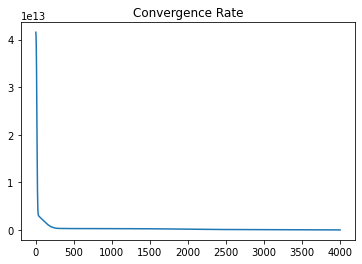

In [47]:
plt.title('Convergence Rate')
plt.plot(fitting_amff.history['loss'])
plt.show()

In [48]:
ann_future_model_prediction_on_training = ann_model_for_future.predict(input_data_tf)


In [49]:
future_data, scaled_future_data, future_dates = generate_future_data(input_data[:,1], 10)
all_cases_future = ann_model_for_future.predict(scaled_future_data)

In [50]:
ann_model_for_future_customize = ann_model_for_future.customize()
ann_model_for_future_customize.evaluate(input_data_tf, output_data_tf)

24/24 [==============================] - 0s 2ms/step - loss: 13751235584.0000 - mean_absolute_error: 46959.2109


[13751235584.0, 46959.2109375]

In [56]:
#print(ann_model_for_future_customize.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"]))

In [58]:
df_PRE = pd.DataFrame(all_cases_future, index = future_dates, columns = ['Confirmed', 'Deaths', 'Recoveries'])

df_PRE.info()
df_PRE

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 23/06/22 to 03/07/22
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Confirmed   11 non-null     float32
 1   Deaths      11 non-null     float32
 2   Recoveries  11 non-null     float32
dtypes: float32(3)
memory usage: 220.0+ bytes


,Confirmed,Deaths,Recoveries
23/06/22,27395122.0,135593.187500,27821734.0
24/06/22,27452918.0,135651.031250,28002298.0
25/06/22,27510546.0,135706.593750,28183580.0
26/06/22,27568022.0,135759.781250,28365598.0
27/06/22,27625338.0,135810.640625,28548352.0
28/06/22,27682494.0,135859.171875,28731832.0
29/06/22,27739490.0,135905.312500,28916056.0
30/06/22,27796318.0,135949.109375,29101020.0
01/07/22,27852978.0,135990.468750,29286716.0
02/07/22,27909466.0,136029.421875,29473172.0


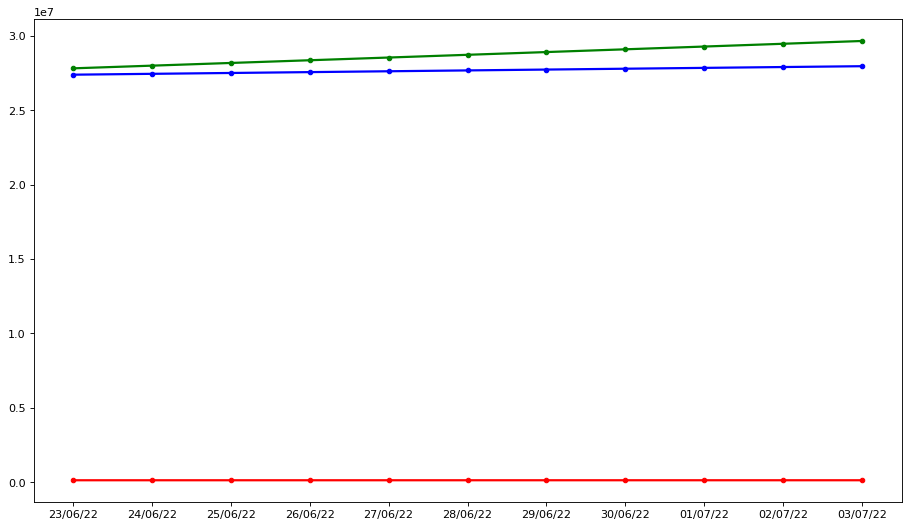

In [60]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
plt.plot()

plt.plot(df_PRE.index,df_PRE['Confirmed'],color='Blue',marker='o',linewidth=2, markersize=4)
plt.plot(df_PRE.index,df_PRE['Deaths'],color='red',marker='o',linewidth=2, markersize=4)
plt.plot(df_PRE.index,df_PRE['Recoveries'],color='green',marker='o',linewidth=2, markersize=4)

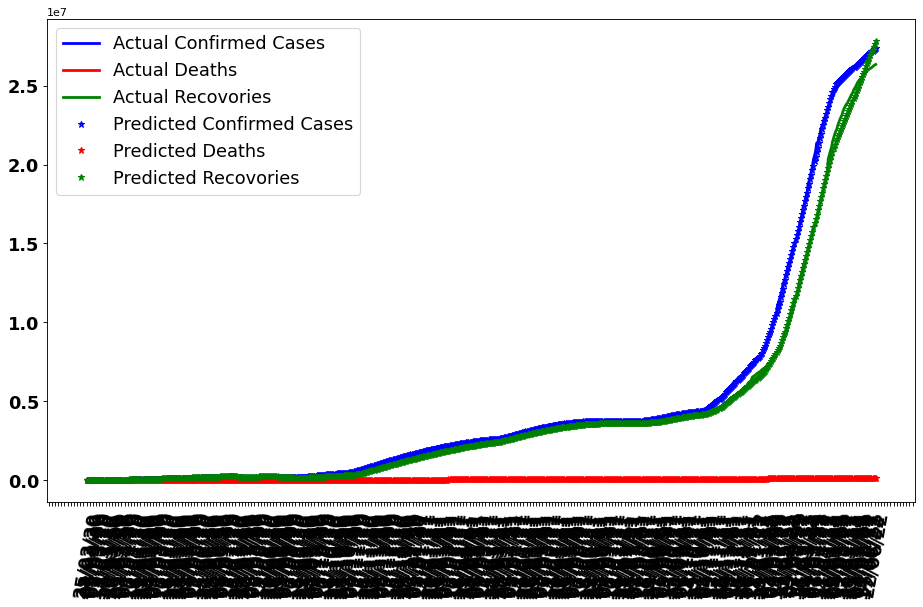

In [61]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Fitting ANN Model on Training Data")
plt.plot(dates, output_data_tf[:,0], 'b', output_data_tf[:,1], 'r', output_data_tf[:,2], 'g', linewidth = 2.5)
plt.plot(dates, 
         ann_future_model_prediction_on_training[:,0], '*b', 
         ann_future_model_prediction_on_training[:,1], '*r', 
         ann_future_model_prediction_on_training[:,2], '*g')
plt.legend(['Actual Confirmed Cases', 'Actual Deaths','Actual Recovories', 'Predicted Confirmed Cases', 
            'Predicted Deaths','Predicted Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()

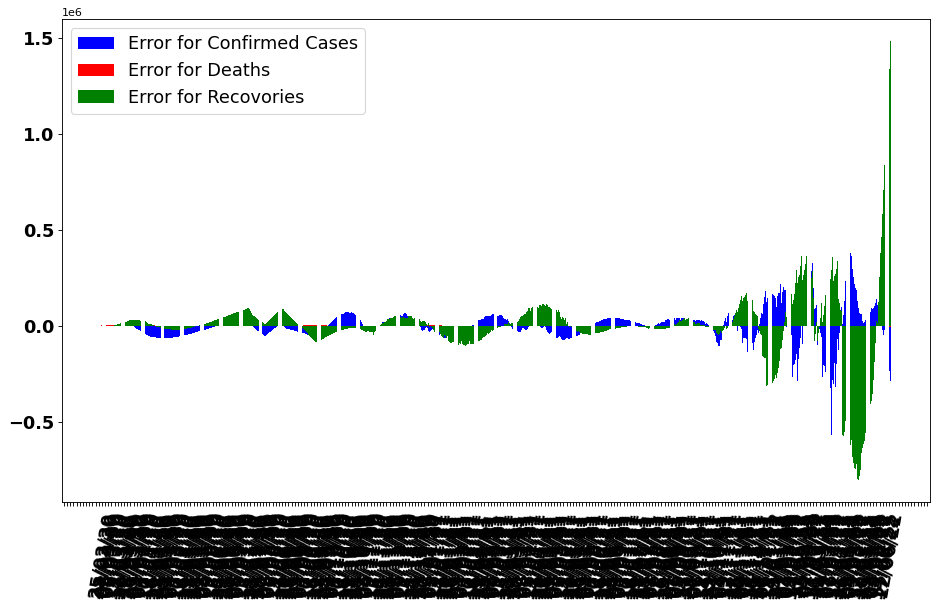

In [62]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Error Graph between Predicted and Actual Values")
plt.bar(dates,(ann_future_model_prediction_on_training[:,0].reshape(-1,) - output_data_tf[:,0]), color = 'b')
plt.bar(dates,(ann_future_model_prediction_on_training[:,1].reshape(-1,) - output_data_tf[:,1]), color = 'r')
plt.bar(dates,(ann_future_model_prediction_on_training[:,2].reshape(-1,) - output_data_tf[:,2]), color = 'g')
plt.legend(['Error for Confirmed Cases', 'Error for Deaths','Error for Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()

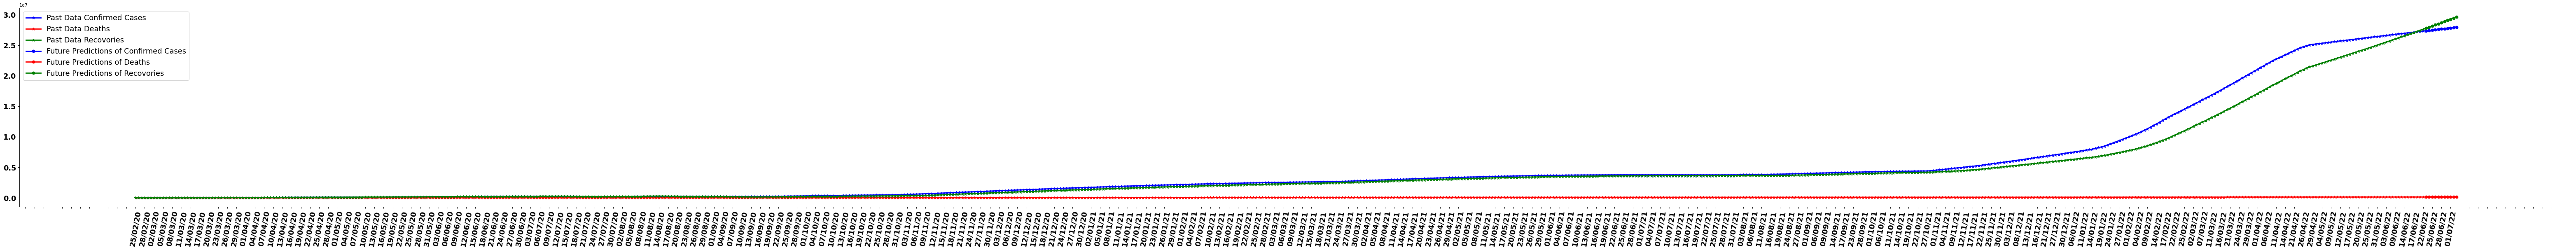

In [63]:
figure(num=None, figsize=(100, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=3.0)) # Skip x-axis ticks by ratio mentioned by base (float value)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Fitting ANN Model on Training Data")
plt.plot(dates, 
         ann_future_model_prediction_on_training[:,0], '-*b', 
         ann_future_model_prediction_on_training[:,1], '-*r', 
         ann_future_model_prediction_on_training[:,2], '-*g',
         future_dates, all_cases_future[:,0], '-ob', 
         future_dates, all_cases_future[:,1], '-or', 
         future_dates, all_cases_future[:,2], '-og', 
         linewidth = 2.5)
plt.legend(['Past Data Confirmed Cases', 'Past Data Deaths','Past Data Recovories', 'Future Predictions of Confirmed Cases', 
            'Future Predictions of Deaths','Future Predictions of Recovories'], fontsize=16)
plt.xticks(rotation=80, weight='bold');
plt.yticks(weight='bold')
plt.show()